In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Imports Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

#Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Ajoute le dossier parent au 'path' pour trouver 'src'
sys.path.append('../src')
from src.preprocess import normalize_flux

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [2]:
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

print("Loading data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

print("Normalizing (detrending) data...")
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1).values
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1).values
print("Normalization complete.")

#CNN Preparation
print("Preparing data for CNN...")
X_train_cnn = X_train_normalized[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print(f"Shape of X_train_cnn: {X_train_cnn.shape}")
print(f"Class weights: {class_weight_dict}")
print("--- Preparation complete ---")

Loading data...
Normalizing (detrending) data...
Normalization complete.
Preparing data for CNN...
Shape of X_train_cnn: (5087, 3197, 1)
Class weights: {0: np.float64(0.5036633663366337), 1: np.float64(68.74324324324324)}
--- Preparation complete ---


In [3]:
# Same simplified architecture as v2
# which solved the overfitting problem.
print("Building v3 model architecture...")

INPUT_SHAPE = (X_train_cnn.shape[1], 1) # (3197, 1)

model_v3 = Sequential([
    # Use the 'Input' layer to define the shape (cleaner code)
    Input(shape=INPUT_SHAPE),

    # --- Block 1 (Small) ---
    Conv1D(filters=8, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # --- Block 2 (Small) ---
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # --- Block 3 (Small) ---
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # --- Classification Head (Small) ---
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.6), # Keep high dropout to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Print model
model_v3.summary()

Building v3 model architecture...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

In [4]:
# Stabilizers

# Define the path to save our best model
MODEL_SAVE_PATH = '../models/cnn_model_v3.keras'

# 1. ModelCheckpoint: Save the best model found during training
# We will monitor 'val_pr_auc' (our key metric)
checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_pr_auc',
    mode='max',           # MAXIMIZE PR-AUC
    save_best_only=True,  # Only save if it's better than the last best
    verbose=1
)

# 2. EarlyStopping: Stop training if the model stops improving
# This prevents wasting time and capturing the "crash"
early_stopping_cb = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=5,           # Stop if no improvement for 5 epochs
    verbose=1,
    restore_best_weights=True # Automatically restore the best model weights at the end
)

CALLBACK_LIST = [checkpoint_cb, early_stopping_cb]

# 3. Compile the model with a SLOWER learning rate
print("Compiling v3 model with lower learning rate (0.0001)...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')

model_v3.compile(
    optimizer=Adam(learning_rate=0.0001), # 10x slower
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)

print("Model compiled.")

Compiling v3 model with lower learning rate (0.0001)...
Model compiled.


In [5]:
# Train
print("Starting v3 training...")

# We can set a high epoch count (1) (e.g., 50)
# EarlyStopping will stop it automatically when it peaks.

history_v3 = model_v3.fit(
    X_train_cnn,
    y_train,
    epochs=50, # (1)
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weight_dict,
    callbacks=CALLBACK_LIST
)

print("Training finished.")

Starting v3 training...
Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6456 - loss: 0.9037 - pr_auc: 0.0049
Epoch 1: val_pr_auc improved from None to 0.00981, saving model to ../models/cnn_model_v3.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5663 - loss: 0.8792 - pr_auc: 0.0083 - val_accuracy: 0.0246 - val_loss: 0.9595 - val_pr_auc: 0.0098
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3777 - loss: 0.6226 - pr_auc: 0.0113
Epoch 2: val_pr_auc improved from 0.00981 to 0.01385, saving model to ../models/cnn_model_v3.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4063 - loss: 0.8328 - pr_auc: 0.0202 - val_accuracy: 0.0351 - val_loss: 1.0969 - val_pr_auc: 0.0139
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4041 - loss: 0.6559 - pr_auc: 0.0251
Epoch 3: val_pr_auc improved from 0.01385 to 0.01490, saving model to ../models/cnn_model_v3.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.4

In [6]:
# Thanks to 'restore_best_weights=True', the 'model_v3' object
# already has the weights from the best epoch.

print("Evaluating model v3 (with best weights)...")

# 1. Get probabilities
y_pred_proba_cnn_v3 = model_v3.predict(X_test_cnn).flatten()

# 2. Convert to classes (0 or 1)
# We still use 0.5 as the threshold for now
y_pred_cnn_v3 = (y_pred_proba_cnn_v3 > 0.5).astype(int)

# 3. Confusion Matrix
print("\nConfusion Matrix (CNN v3):")
cm_cnn_v3 = confusion_matrix(y_test, y_pred_cnn_v3)
print(cm_cnn_v3)

# 4. Classification Report
print("\nClassification Report (CNN v3):")
print(classification_report(y_test, y_pred_cnn_v3, target_names=['No Planet (0)', 'Planet (1)']))

Evaluating model v3 (with best weights)...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Confusion Matrix (CNN v3):
[[ 16 549]
 [  0   5]]

Classification Report (CNN v3):
               precision    recall  f1-score   support

No Planet (0)       1.00      0.03      0.06       565
   Planet (1)       0.01      1.00      0.02         5

     accuracy                           0.04       570
    macro avg       0.50      0.51      0.04       570
 weighted avg       0.99      0.04      0.05       570



Plotting training history...


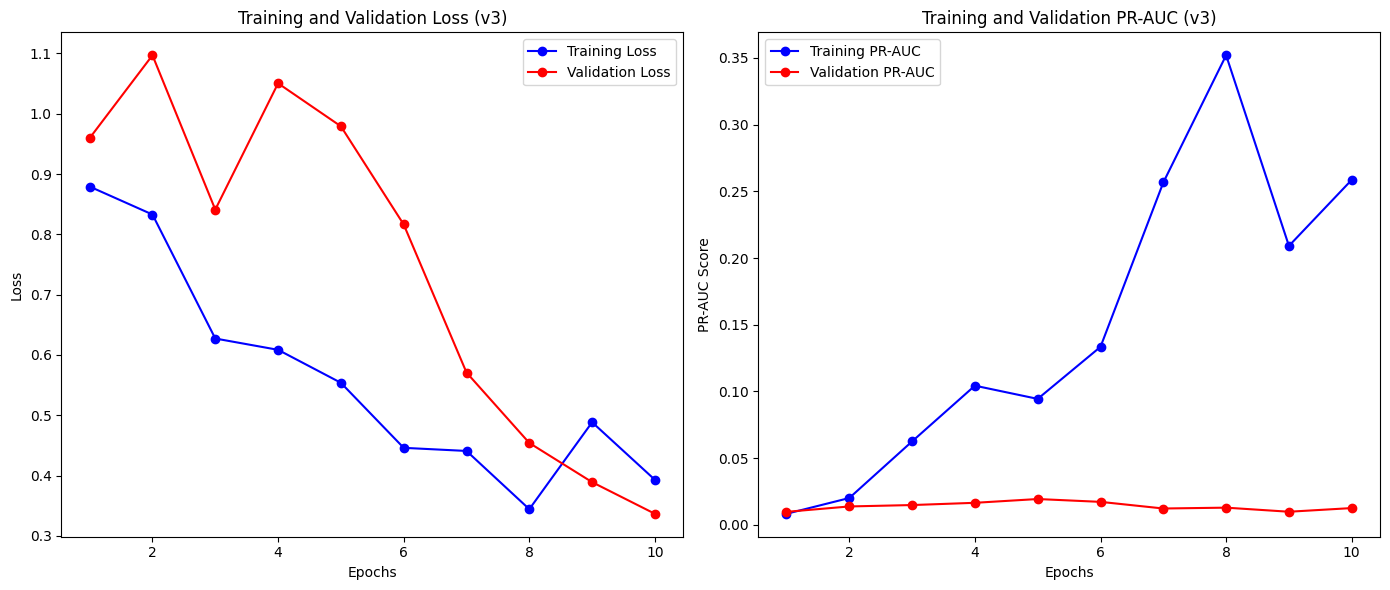

In [7]:
print("Plotting training history...")

history_dict = history_v3.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']

# Find out how many epochs it *actually* ran
actual_epochs = len(loss)
epochs_range = range(1, actual_epochs + 1)

# --- 1. Plot Loss ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (v3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- 2. Plot PR-AUC ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, pr_auc, 'bo-', label='Training PR-AUC')
plt.plot(epochs_range, val_pr_auc, 'ro-', label='Validation PR-AUC')
plt.title('Training and Validation PR-AUC (v3)')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()

plt.tight_layout()
plt.show()